## Import Libraries

In [2]:
# Library to support working with data
import pandas as pd
import numpy as np

# Data Normalization Support Library
from sklearn.preprocessing import MinMaxScaler

# Performance metrics calculation support library
from sklearn.metrics import r2_score, explained_variance_score, mean_squared_error, mean_absolute_percentage_error, mean_absolute_error, mean_squared_log_error

# Graphing support library
from matplotlib import ticker
import matplotlib.pyplot as plt


## Data preprocessing

### Read data

In [3]:
df = pd.read_csv('../../../../Dataset/CTLT.csv')
df


,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-02,30.860001,31.260000,30.240000,30.910000,30.910000,1201700
1,2019-01-03,30.660000,30.660000,29.290001,29.840000,29.840000,1149900
2,2019-01-04,30.049999,31.360001,29.940001,31.080000,31.080000,3530400
3,2019-01-07,31.020000,32.180000,30.850000,32.000000,32.000000,1063400
4,2019-01-08,32.340000,33.060001,32.150002,32.790001,32.790001,1391000
...,...,...,...,...,...,...,...
1114,2023-06-06,37.910000,39.049999,37.580002,38.820000,38.820000,2261700
1115,2023-06-07,39.160000,40.029999,38.250000,39.959999,39.959999,4382500
1116,2023-06-08,39.700001,39.840000,36.750000,39.000000,39.000000,9705500
1117,2023-06-09,39.250000,40.110001,38.480000,38.810001,38.810001,4493800


### Reset index

In [4]:
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set the 'Date' column as the index value
df.set_index('Date', inplace=True)

In [5]:
# Select the Close column as the dependent variable
df_Close = df[['Close']]
df_Close = df_Close.reset_index(drop=True)

### Data normalization

In [6]:
# Min-max normalization
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(np.array(df_Close))

### Data splitting

In [7]:
# Split the data into training, validation and test dataset in a ratio of 6:2:2
train_size = int(0.7 * len(data_scaled))
val_size = int(0.1 * len(data_scaled))
test_size = len(data_scaled) - train_size - val_size

train_data = data_scaled[: train_size]
val_data = data_scaled[train_size : train_size + val_size]
test_data = data_scaled[train_size + val_size :]

## Model training and testing

In [8]:
# Install library pmdarima
!pip install pmdarima

### Training process

In [9]:
# Preparing training data
x_train = np.arange(train_size).reshape(-1, 1)
y_train = train_data.reshape(-1)

In [10]:
# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-4202.751, Time=0.82 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4205.376, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4204.364, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4204.265, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4205.524, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4201.616, Time=0.18 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.334 seconds


In [11]:
# Fit the model
model.fit(y_train)

ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

### Validate Processing

In [12]:
# Preparing validation data
x_val = np.array(range(train_size, train_size + val_size)).reshape(-1, 1)
y_val = np.array(val_data).reshape(-1)
y_pred_val = model.predict(n_periods = len(y_val))

### Testing Processing

In [13]:
x_test = np.array(range(test_size, train_size + val_size + test_size)).reshape(-1, 1)
y_test = np.array(test_data).reshape(-1)
y_pred = model.predict(n_periods=len(y_test))

### Evaluate Model

In [14]:
# Evaluate the accuracy of validation
y_val = scaler.inverse_transform(np.array([y_val]).reshape(-1, 1))
y_pred_val = scaler.inverse_transform(np.array([y_pred_val]).reshape(-1, 1))

val_mape = mean_absolute_percentage_error(y_val, y_pred_val)
val_mse = mean_squared_error(y_val, y_pred_val)
val_rmse = np.sqrt(val_mse)
val_msle = mean_squared_log_error(y_val, y_pred_val)

print(f"MAPE on Validate set: ", val_mape)
print(f"RMSE on Validate set: ", val_rmse)
print(f"MSLE on Validate set: ", val_msle)

MAPE on Validate set:  0.051767613561339416
RMSE on Validate set:  6.4571320200060836
MSLE on Validate set:  0.003933105981433041


In [15]:
# Evaluate the accuracy of test
y_test = scaler.inverse_transform(np.array([y_test]).reshape(-1, 1))
y_pred = scaler.inverse_transform(np.array([y_pred]).reshape(-1, 1))

test_mape = mean_absolute_percentage_error(y_test, y_pred)
test_mse = mean_squared_error(y_test, y_pred)
test_rmse = np.sqrt(test_mse)
test_msle = mean_squared_log_error(y_test, y_pred)

print(f"MAPE on Test dataset: ", test_mape)
print(f"RMSE on Test dataset: ", test_rmse)
print(f"MSLE on Test dataset: ", test_msle)

MAPE on Test dataset:  0.7901545193445668
RMSE on Test dataset:  43.42378999544429
MSLE on Test dataset:  0.3724374883610699


## Predicting the next 30 days

### Preparing the prediction data

In [16]:
# The process of creating index predict next 30 days
last_index =  df_Close.index[-1]

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index + 1, last_index + 31)).reshape(-1, 1)

### Prediction process

In [17]:
# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days))
y_next_30_days = scaler.inverse_transform(np.array([y_next_30_days]).reshape(-1, 1))

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days.flatten())

Predicted closing prices for the next 30 days:
[101.18 101.18 101.18 101.18 101.18 101.18 101.18 101.18 101.18 101.18
 101.18 101.18 101.18 101.18 101.18 101.18 101.18 101.18 101.18 101.18
 101.18 101.18 101.18 101.18 101.18 101.18 101.18 101.18 101.18 101.18]


### Preparing the forecast date index


In [18]:
# Get the last date from the current index
last_date = df.index[-1]

# Add one day to the last date
next_date = last_date + pd.DateOffset(days=1)

# Create a list of indices starting from the next date for 30 days
index_next_30_days = pd.date_range(start=next_date, periods=30).tolist()

## Visualization

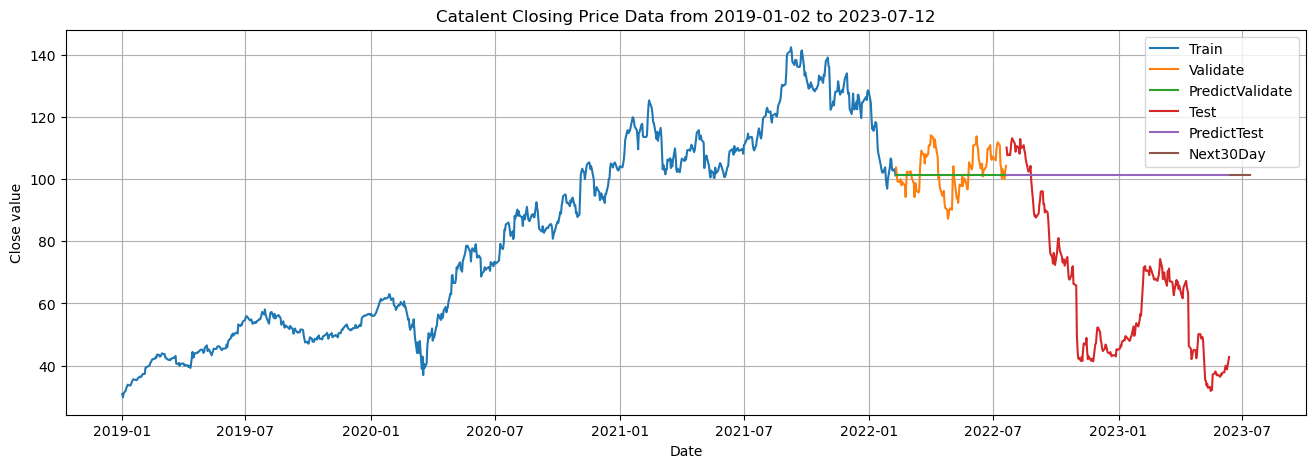

In [19]:
# Drawing
plt.figure(figsize=(16, 5))

plt.plot(df.index[:train_size], scaler.inverse_transform(np.array([y_train]).reshape(-1, 1)))

plt.plot(df.index[train_size : train_size + val_size], y_val)

plt.plot(df.index[train_size : train_size + val_size], y_pred_val)

plt.plot(df.index[train_size + val_size :], y_test)

plt.plot(df.index[train_size + val_size :], y_pred)

plt.plot(index_next_30_days, y_next_30_days)

plt.legend(['Train', 'Validate', 'PredictValidate', 'Test', 'PredictTest', 'Next30Day'])

plt.grid()
plt.title(f"Catalent Closing Price Data from {df.index[0].strftime('%Y-%m-%d')} to {index_next_30_days[-1].strftime('%Y-%m-%d')}")
plt.xlabel("Date")
plt.ylabel("Close value")
plt.savefig('../Image/ARIMA_712_CTLT.png')
plt.show()